In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow import keras

from collections import Counter

from bing_image_downloader import downloader

dataset_dir = '../../data/'

train_dir = dataset_dir + 'train/'
valid_dir = dataset_dir + 'valid/'
test_dir = dataset_dir + 'test/'

size = 180
image_size = (size, size)
input_shape = (size, size, 3)
batch_size = 32

In [33]:
def get_top_tags():
      train_dataset = image_dataset_from_directory(
      train_dir,
      image_size=image_size,
      batch_size=batch_size
      )

      class_names = train_dataset.class_names

      train_labels = np.concatenate([y for _, y in train_dataset])

      class_counter = Counter(train_labels)

      top_tags = [class_names[class_index] for class_index, _ in class_counter.most_common(3)]

      return top_tags

In [34]:
def generate_flow(data_dir, included_classes, augment = False):
  generator = ImageDataGenerator(rescale=1.0/255.0, preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

  if augment:
    generator = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )


  return generator.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=included_classes
  )

In [35]:
def get_more_img(search):
    downloader.download(search, output_dir=valid_dir, verbose=False)
    downloader.download(search, output_dir=test_dir, verbose=False)

In [36]:
get_top_tags()

Found 84635 files belonging to 525 classes.


['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

In [37]:
included_tags = get_top_tags()

Found 84635 files belonging to 525 classes.


In [38]:

train_generator = generate_flow(train_dir, included_tags, augment=True)
valid_generator = generate_flow(valid_dir, included_tags, augment=True)
test_generator = generate_flow(test_dir, included_tags)

print(train_generator.class_indices)


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
{'RUFOUS TREPE': 0, 'HOUSE FINCH': 1, 'OVENBIRD': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


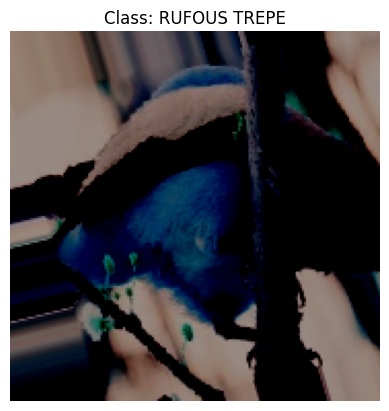

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


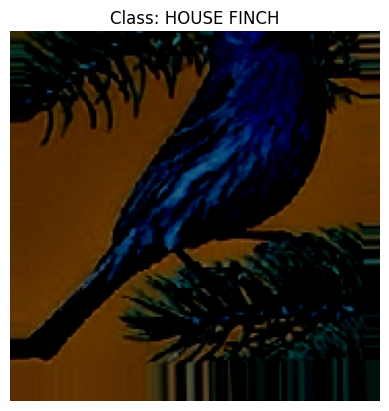

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


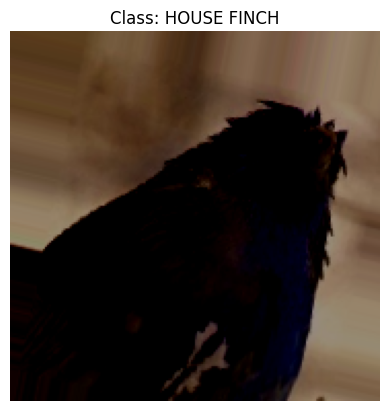

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


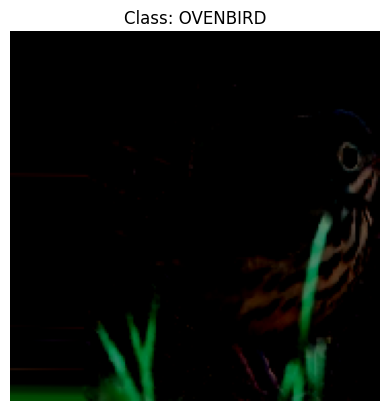

In [39]:
for batch_images, batch_labels in train_generator:

    for i in range(len(batch_images)):
        if i > 3:
            break
        label = np.argmax(batch_labels[i])  

        plt.figure()
        plt.imshow(batch_images[i])
        class_name = included_tags[label]
        plt.title(f'Class: {class_name}')
        plt.axis('off')
        plt.show()

        i += 1
    if i > 3:
            break

In [40]:
def build_model(model_name):
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

  inputs = keras.Input(shape=input_shape)
  conv_base.trainable=False

  x = conv_base(inputs)  
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(3, activation='softmax')(x)
  model = keras.Model(inputs, outputs)

  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath=f'./models/{model_name}.keras',
          monitor='val_loss'
      )
  ]

  return model, callbacks

In [41]:
def train(model, callbacks):
  return model.fit(
    train_generator,
    epochs=20,
    batch_size=batch_size,
    validation_data=valid_generator,
    callbacks=callbacks
  ) 

In [42]:
def evaluate_model(model):
  model = keras.models.load_model(f'./models/{model}.keras')

  test_loss, test_acc = model.evaluate(test_generator)
  print(f'Test accuracy: {test_acc:.3f}')

  class_names = list(test_generator.class_indices.keys())

  test_generator.reset()
  y_true = test_generator.classes
  y_pred = model.predict(test_generator)
  y_pred_classes = np.argmax(y_pred, axis=1)

  print('Classification Report:')
  print(classification_report(y_true, y_pred_classes, target_names=class_names))

  print('Confusion Matrix:')
  cm = confusion_matrix(y_true, y_pred_classes)
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [43]:
base_model, base_callbacks = build_model('base_model')

In [44]:
base_history = train(base_model, base_callbacks)

Epoch 1/20
24/24 [==============================] - 57s 2s/step - loss: 4.9085 - accuracy: 0.6438 - val_loss: 0.4321 - val_accuracy: 0.9333
Epoch 2/20
24/24 [==============================] - 55s 2s/step - loss: 1.0806 - accuracy: 0.8535 - val_loss: 0.0582 - val_accuracy: 0.9333
Epoch 3/20
24/24 [==============================] - 56s 2s/step - loss: 0.4464 - accuracy: 0.9207 - val_loss: 5.5947e-05 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 56s 2s/step - loss: 0.4425 - accuracy: 0.9382 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 57s 2s/step - loss: 0.4659 - accuracy: 0.9247 - val_loss: 0.9295 - val_accuracy: 0.9333
Epoch 6/20
24/24 [==============================] - 56s 2s/step - loss: 0.3492 - accuracy: 0.9368 - val_loss: 5.5232e-06 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - 55s 2s/step - loss: 0.3151 - accuracy: 0.9435 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 8/20
2

In [45]:
for tag in included_tags:
    get_more_img(tag)

[%] Downloading Images to d:\Source\AI&ML\FML\CSCN8010-lab-submissions\students_submissions\7526387\..\..\data\valid\RUFOUS TREPE
[!] Issue getting: http://www.coopershawks.com/media/2015 Pics/rufous cameo 03-15-15.jpg
[!] Error:: URL can't contain control characters. '/media/2015 Pics/rufous cameo 03-15-15.jpg' (found at least ' ')
[Error]Invalid image, not saving https://arghyadas98.files.wordpress.com/2016/08/rufous-treepie.jpg?w=964&amp;h=1024

[!] Issue getting: https://arghyadas98.files.wordpress.com/2016/08/rufous-treepie.jpg?w=964&amp;h=1024
[!] Error:: Invalid image, not saving https://arghyadas98.files.wordpress.com/2016/08/rufous-treepie.jpg?w=964&amp;h=1024

[!] Issue getting: http://www.bushpea.com/bd/ph/vik/im/rufous fieldwren 03.jpg
[!] Error:: URL can't contain control characters. '/bd/ph/vik/im/rufous fieldwren 03.jpg' (found at least ' ')
[Error]Invalid image, not saving https://aniwayphotobulous.files.wordpress.com/2015/10/dsc07395.jpg?w=768&amp;h=511&amp;crop=1

[!]

In [46]:
added_data_model, added_data_callbacks = build_model('added_data_model')

In [47]:
added_data_history = train(added_data_model, added_data_callbacks)

Epoch 1/20
24/24 [==============================] - 56s 2s/step - loss: 4.1081 - accuracy: 0.6734 - val_loss: 0.7981 - val_accuracy: 0.8667
Epoch 2/20
24/24 [==============================] - 56s 2s/step - loss: 0.8635 - accuracy: 0.8737 - val_loss: 0.2860 - val_accuracy: 0.9333
Epoch 3/20
24/24 [==============================] - 55s 2s/step - loss: 0.5600 - accuracy: 0.9180 - val_loss: 0.1284 - val_accuracy: 0.9333
Epoch 4/20
24/24 [==============================] - 54s 2s/step - loss: 0.4335 - accuracy: 0.9234 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 55s 2s/step - loss: 0.6091 - accuracy: 0.9180 - val_loss: 0.0553 - val_accuracy: 0.9333
Epoch 6/20
24/24 [==============================] - 55s 2s/step - loss: 0.3466 - accuracy: 0.9422 - val_loss: 0.0591 - val_accuracy: 0.9333
Epoch 7/20
24/24 [==============================] - 55s 2s/step - loss: 0.5027 - accuracy: 0.9315 - val_loss: 0.0474 - val_accuracy: 0.9333
Epoch 8/20
24/24 [==

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.000
1/1 [==============================] - 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

RUFOUS TREPE       0.20      0.20      0.20         5
 HOUSE FINCH       0.40      0.40      0.40         5
    OVENBIRD       0.20      0.20      0.20         5

    accuracy                           0.27        15
   macro avg       0.27      0.27      0.27        15
weighted avg       0.27      0.27      0.27        15

Confusion Matrix:
[[1 1 3]
 [2 2 1]
 [2 2 1]]


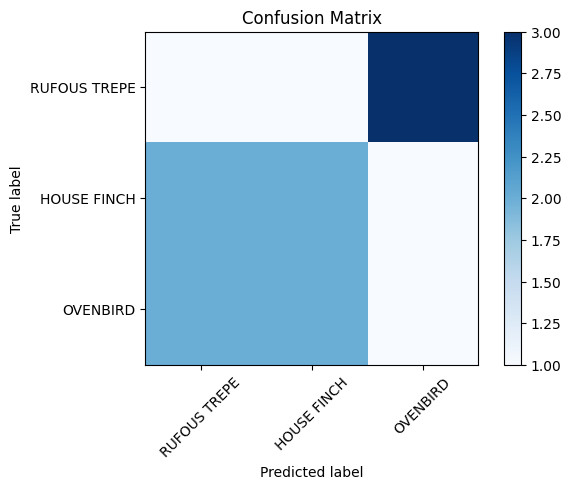

1/1 [==============================] - 1s 1s/step - loss: 2.6226e-07 - accuracy: 1.0000
Test accuracy: 1.000
1/1 [==============================] - 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

RUFOUS TREPE       0.20      0.20      0.20         5
 HOUSE FINCH       0.20      0.20      0.20         5
    OVENBIRD       0.20      0.20      0.20         5

    accuracy                           0.20        15
   macro avg       0.20      0.20      0.20        15
weighted avg       0.20      0.20      0.20        15

Confusion Matrix:
[[1 2 2]
 [2 1 2]
 [2 2 1]]


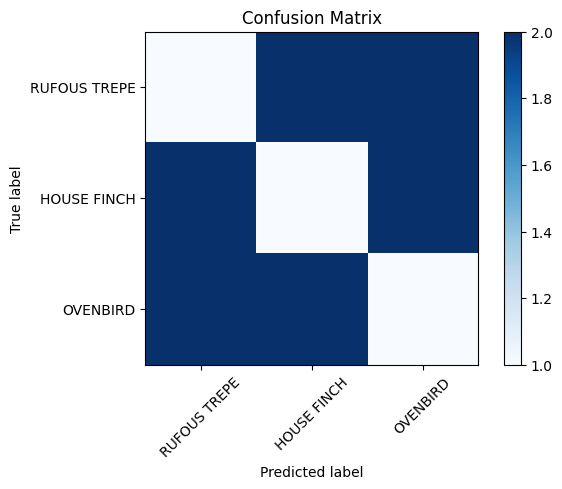

In [48]:

evaluate_model('base_model')
evaluate_model('added_data_model')